In [ ]:
# CNN

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from random import gauss
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

In [2]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [8192] 
# number_samples = [4096, 4915, 5734, 6554, 7373, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
validation_size, noise_floor = 0.33, -95.0#-110.0
max_x, max_y, number_image_channels = 100, 100, 1
pic_cell_size, cell_size = 1, 10
ss_shape = 'point' # shape = {'circle', 'square', 'point'} 
ss_param = None #ss_param overrides ss_shape if exists. make it None if you want to use ss_shape
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope, IS_SOLID = 'log', 5, False  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_txs_num = 4
propagation_model = 'log' # 'splat', 'log', 'testbed'
noise, std = True, 1 # False for splat
    
STATIC_SENSORS = True
sensors_num = 900
if STATIC_SENSORS:
    sensors_file_path = "../../java_workspace/research/commons/resources/sensors/square" \
    + str(max(max_x, max_y)) + "/" + str(sensors_num) + "/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 6
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8

dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'models/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + "/" + ("static_" if STATIC_SENSORS else "dynamic_"
                                                       ) + ss_shape + '_sensors' + "/" + style + "/" + color + (
    "" if ss_shape == 'point' else ("/" + intensity_degradation + '_' + str(slope))) + "/" + str(sensors_num) + "sensors" + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir

'models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/images'

In [4]:
# LOAD DATA
num_columns = (sensors_num if STATIC_SENSORS else sensors_num * 3 + 1) + max_txs_num * 3 + 1 + 3
cols = [i for i in range(num_columns)]
dataset_name = "STRONGEST_FIXEDPOWERS_150000_min0_max4TXs_900sensor_square100grid_log_alpha3.5_noisy_std1.0_2020_11_21_12_40.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name)

dataframe = pd.read_csv('../../java_workspace/research/localization/resources/data/'
                        + dataset_name, delimiter=',', header=None, names=cols, dtype=np.float64)

dataframe.reset_index(drop=True, inplace=True)


data_reg = dataframe.values
# data_reg[data_reg == '-Infinity'] = -float('inf')
data_reg[data_reg < noise_floor] = noise_floor
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]

if STATIC_SENSORS:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe

In [6]:
data_reg.shape

(150000, 916)

In [7]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float,
                 noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, 
                 ss_shape= 'circle', ss_param=None, intensity_degradation="log", max_ss_power: float=0,
                pic_cell_size: int = 1):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels, max_x * pic_cell_size, max_y * pic_cell_size), 
                         dtype=float_memory_used)
#         if not STATIC_SENSORS:
        sss_num = int(data[0]) if not STATIC_SENSORS else sensors_num
#             print(pus_num)
        for ss_i in range(sss_num):
            ss_x = int(data[ss_i * 3 + 1]) if not STATIC_SENSORS else int(sensors_location[ss_i].x)
            ss_x = max(0, min(max_x * pic_cell_size - 1, ss_x * pic_cell_size)) # limit to borders
            ss_y = int(data[ss_i * 3 + 2]) if not STATIC_SENSORS else int(sensors_location[ss_i].y)
            ss_y = max(0, min(max_y * pic_cell_size - 1, ss_y * pic_cell_size)) # limit to borders
            ss_p = data[ss_i * 3 + 3] if not STATIC_SENSORS else data[ss_i]
#                 print(pu_x, pu_y, pu_p)
            if ss_param is None:
                ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
            else:
                ss_param_p = ss_param
            points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p, 
                                        max_x = max_x * pic_cell_size, max_y = max_y * pic_cell_size)
            ss_channel = 0
            for point in points:
                if 0 <= point.p.x < max_x * pic_cell_size and 0 <= point.p.y < max_y * pic_cell_size: # TODO should pass image size
                    if not IS_SOLID:
                        if intensity_degradation == "linear":
                            val = (ss_p - slope * point.dist - noise_floor)/(max_ss_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                val = (ss_p - noise_floor) / (max_ss_power - noise_floor)
                            else:
                                val = (ss_p - slope * 10 * math.log10(point.dist)- noise_floor)/(
                                    max_ss_power - noise_floor)
                    else:
                        val = (ss_p - noise_floor) / (max_ss_power - noise_floor)
                    image[0][ss_channel][point.p.x][point.p.y] += max(val, 0)
#         else:
#             for ss_i in range(sensors_num):
#                 ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
#                     sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
#                 ss_channel = 0 
#                 if ss_param is None:
#                     ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
#                 else:
#                     ss_param_p = ss_param
#                 points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
#                 for point in points:
#                     if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
#                         if intensity_degradation == "linear":
#                             image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
#                                 max_ss_power - noise_floor)
#                         elif intensity_degradation == "log":
#                             if point.dist < 1:
#                                 image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor
#                                                                               ) / (max_ss_power - noise_floor)
#                             else:
#                                 image[0][ss_channel][point.p.x][point.p.y] += (ss_p - 
#                                                                                slope * 10*math.log10(point.dist) -
#                                                                                noise_floor)/(
#                                     max_ss_power - noise_floor)
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
                        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_imag= np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param, max_x: int, max_y: int)-> list:
    # This function returns points+distance around center with defined shape
    if param and type(param).__name__ == 'Circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-r, -max_x), min(r, max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif param and type(param).__name__ == 'Square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center))
                for x in range(-half_side + center.x, half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif not param and shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

In [ ]:
plt.hist(data_reg[:5,(0 if STATIC_SENSORS else 3):(sensors_num if STATIC_SENSORS else sensors_num*3+1)
                  :(1 if STATIC_SENSORS else 3)], bins='auto')

In [11]:
np.amin(data_reg[:, :sensors_num])

-95.0

In [ ]:
plt.hist(data_sensor, bins='auto')

In [7]:
max_ss_power = -float('inf')
for i in range(data_reg.shape[0]):
    ss_num = data_reg[i][0] if not STATIC_SENSORS else sensors_num
    low, high = (0 if STATIC_SENSORS else 3), (sensors_num if STATIC_SENSORS else sensors_num * 3 + 1),
    step = (1 if STATIC_SENSORS else 3)
    max_ss_power = max(max_ss_power, max(data_reg[i, low:high:step]))
print(max_ss_power)

-0.3


In [8]:
max_ss_power = -10.0

In [9]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             ss_shape=ss_shape, 
                             sensors_num=(sensors_num if STATIC_SENSORS else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_ss_power=max_ss_power, ss_param=ss_param, 
                            pic_cell_size=pic_cell_size)
        if style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image

In [9]:
data_reg_bak = data_reg
data_reg = data_reg[:100000,:]

In [21]:
data_reg.shape

(150000, 919)

In [19]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 25000/25000 [05:54<00:00, 70.56it/s] 


In [23]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

1 Point(x=2, y=2)
2 Point(x=2, y=7)
3 Point(x=2, y=12)
4 Point(x=2, y=17)
5 Point(x=2, y=22)
6 Point(x=2, y=27)
7 Point(x=2, y=32)
8 Point(x=2, y=37)
9 Point(x=2, y=42)
10 Point(x=2, y=47)
11 Point(x=2, y=52)
12 Point(x=2, y=57)
13 Point(x=2, y=62)
14 Point(x=2, y=67)
15 Point(x=2, y=72)
16 Point(x=2, y=77)
17 Point(x=2, y=82)
18 Point(x=2, y=87)
19 Point(x=2, y=92)
20 Point(x=2, y=97)
21 Point(x=2, y=102)
22 Point(x=2, y=107)
23 Point(x=2, y=112)
24 Point(x=2, y=117)
25 Point(x=2, y=122)
26 Point(x=2, y=127)
27 Point(x=2, y=132)
28 Point(x=2, y=137)
29 Point(x=2, y=142)
30 Point(x=2, y=147)
31 Point(x=2, y=152)
32 Point(x=2, y=157)
33 Point(x=2, y=162)
34 Point(x=2, y=167)
35 Point(x=2, y=172)
36 Point(x=2, y=177)
37 Point(x=2, y=182)
38 Point(x=2, y=187)
39 Point(x=2, y=192)
40 Point(x=2, y=197)
41 Point(x=7, y=2)
42 Point(x=7, y=7)
43 Point(x=7, y=12)
44 Point(x=7, y=17)
45 Point(x=7, y=22)
46 Point(x=7, y=27)
47 Point(x=7, y=32)
48 Point(x=7, y=37)
49 Point(x=7, y=42)
50 Point(x=7,

In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

In [ ]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [ ]:
print(count)
print(idxx[3])

In [17]:
imm = read_image(3)

In [11]:
imm[0].shape

(1, 200, 200)

In [ ]:
data_reg[:,-1].shape

In [15]:
data_reg[3][sensors_num:]

array([ 54.,  81.,   0.,   4.,  14.,  90., -15.,  16.,  85., -10.,  11.,
        16.,  -5.,  54.,  81.,   0.])

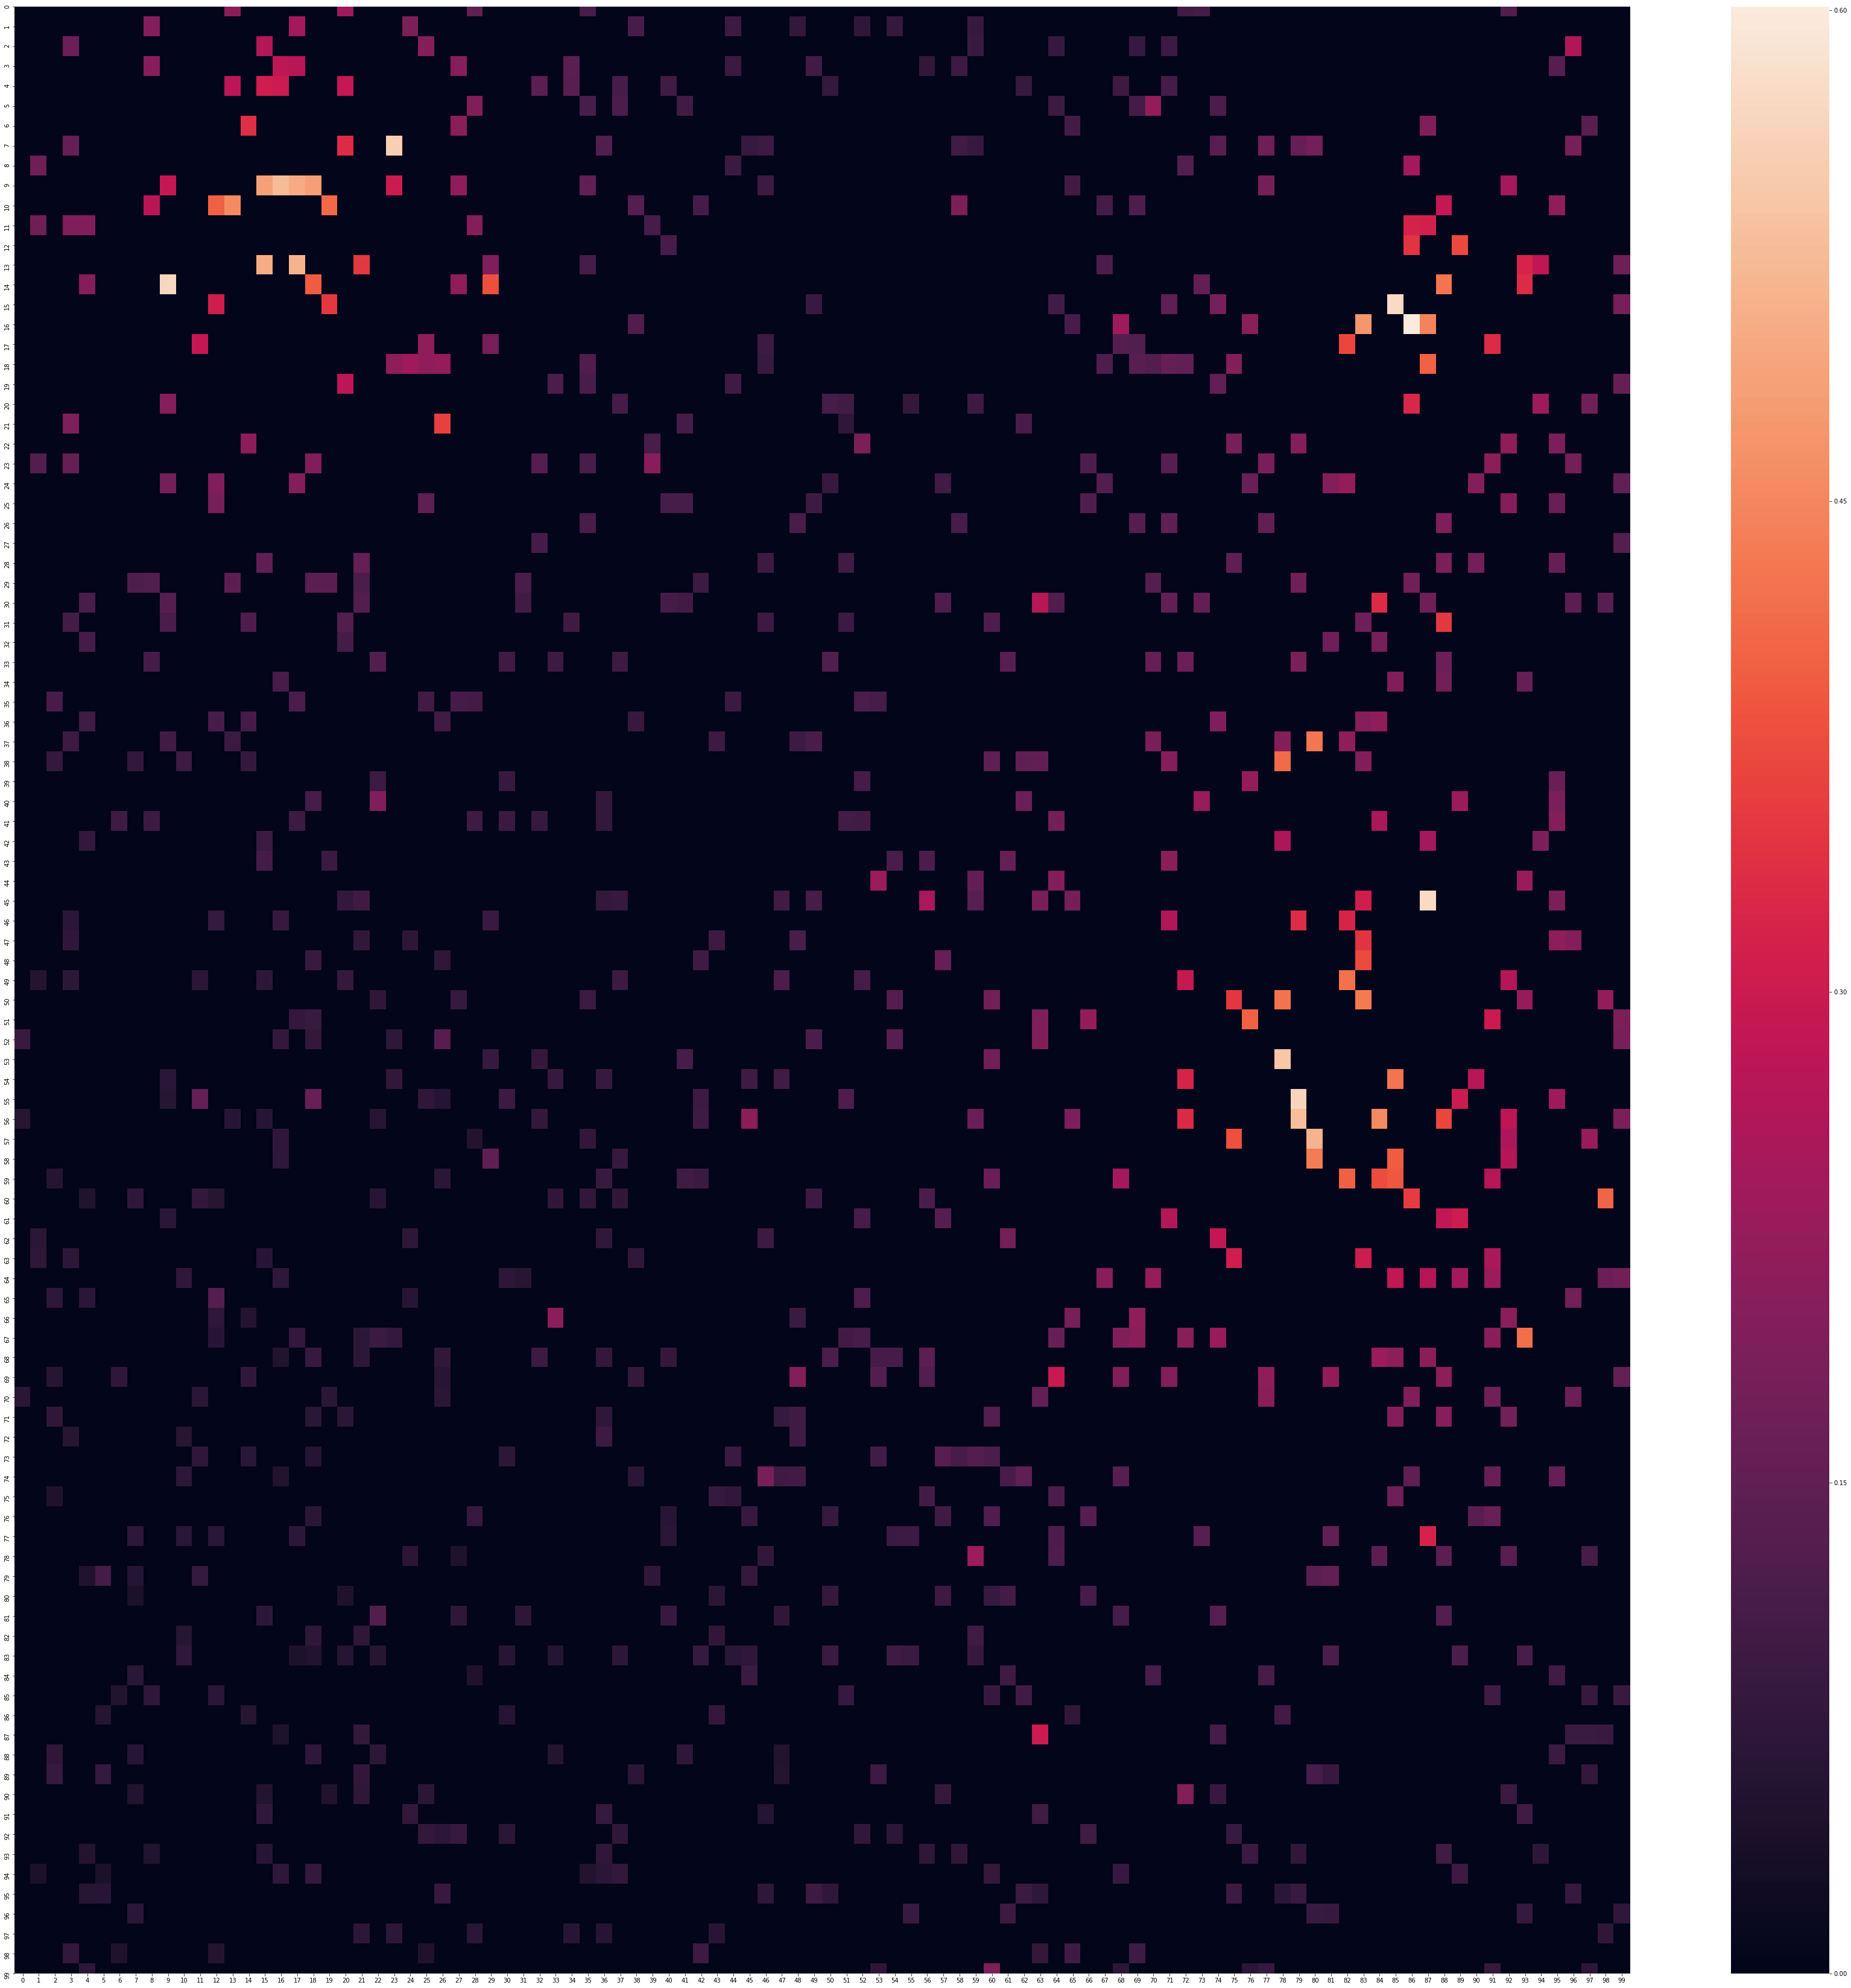

In [18]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][0], ax=ax)

In [35]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
#     cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
    
    if max(max_x, max_y) == 200:
        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
#     cnn.add(layers.Dropout(0.25))
# from here for 1000
    if max(max_x, max_y) == 1000:
        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn.add(layers.Dense(3, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, SENSOR_NUM:int, STATIC:bool=False):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.STATIC = STATIC
        self.SENSOR_NUM = SENSOR_NUM
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size, 3), dtype=self.float_memory_used)
        for i in range(size):
            y_offset = (self.SENSOR_NUM if self.STATIC else int(self.dataset[idx * self.batch_size + i][0])*3+1)
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i][0] = self.dataset[idx * self.batch_size + i][y_offset] #x
            batch_y[i][1] = self.dataset[idx * self.batch_size + i][y_offset + 1] #y
            batch_y[i][2] = self.dataset[idx * self.batch_size + i][y_offset + 2] #p
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def location_mae(y_true, y_pred):
    res = y_pred[:,:2] - y_true[:,:2]
    return K.mean(K.sqrt(K.square(res)))

def power_mae(y_true, y_pred):
    res = y_pred[:,-1] - y_true[:,-1]
    return K.mean(K.abs(res))

def total_mae(y_true, y_pred):
    return location_mae(y_true, y_pred) + power_mae(y_true, y_pred)

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [16]:
cnn = cnn_model(10, 0, 0)

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 200, 200)      100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 100, 100)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100, 100)      40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 100, 100)      1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 50, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 50, 50)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 50, 50)        5

In [108]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [18]:
number_samples = [8192*2]

In [19]:
# CNN: support batching
TEST = False
mini_batch = 16 if max(max_x, max_y) == 1000 else 256
epochs = 200 if max(max_x, max_y) == 1000 else 200
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_total_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0.1]#[0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
# lambda_vec = [0.01, 0.1, 1]
# lambda_vec = [10]
# MODEL_PATH = 'models/'
average_diff_power, average_location_error = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
all_cnns = []

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss='mse',#custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', 
                        metrics=['mse', 'mae', location_mae, power_mae, total_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'location_mae': location_mae,
                                                 'power_mae': power_mae, 'total_mae': total_mae}) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used, 
                                         STATIC=STATIC_SENSORS, SENSOR_NUM=sensors_num)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      STATIC=STATIC_SENSORS, SENSOR_NUM=sensors_num)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\n\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("\nTrain Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("\nTrain Total Error(all epochs):", min(cnns[lamb_idx].history.history['total_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['total_mae']])
        print("\nTrain Location Error(all epochs):", min(cnns[lamb_idx].history.history['location_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['location_mae']])
        print("\nTrain Power Error(all epochs):", min(cnns[lamb_idx].history.history['power_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['power_mae']])
        
        
        print("\nVal Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("\nVal Total Error(all epochs):", min(cnns[lamb_idx].history.history['val_total_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_total_mae']])
        print("\nVal Location Error(all epochs):", min(cnns[lamb_idx].history.history['val_location_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_location_mae']])
        print("\nVal Power Error(all epochs):", min(cnns[lamb_idx].history.history['val_power_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_power_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , hyper_metric,
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 16384 , New samples: 16384
Validation size: 5407 , starts: 16384 , ends: 21790

Epoch 00001: val_total_mae improved from inf to 109.08794, saving model to models/pictures_200_200/log/static_point_sensors/raw_power_min_max_norm/gray/1600sensors/models/16384/best_model_lambda_0.h5

Epoch 00002: val_total_mae did not improve from 109.08794

Epoch 00003: val_total_mae improved from 109.08794 to 108.58304, saving model to models/pictures_200_200/log/static_point_sensors/raw_power_min_max_norm/gray/1600sensors/models/16384/best_model_lambda_0.h5

Epoch 00004: val_total_mae improved from 108.58304 to 101.49221, saving model to models/pictures_200_200/log/static_point_sensors/raw_power_min_max_norm/gray/1600sensors/models/16384/best_model_lambda_0.h5

Epoch 00005: val_total_mae improved from 101.49221 to 64.72574, saving model to models/pictures_200_200/log/static_point_sensors/raw_power_min_max_norm/gray/1600sensors/models/16384/best_model_lambda_0.h5

Epoch 00006: val_total_m


Epoch 00095: val_total_mae improved from 18.76959 to 18.47756, saving model to models/pictures_200_200/log/static_point_sensors/raw_power_min_max_norm/gray/1600sensors/models/16384/best_model_lambda_0.h5

Epoch 00096: val_total_mae did not improve from 18.47756

Epoch 00097: val_total_mae did not improve from 18.47756

Epoch 00098: val_total_mae did not improve from 18.47756

Epoch 00099: val_total_mae did not improve from 18.47756

Epoch 00100: val_total_mae did not improve from 18.47756

Epoch 00101: val_total_mae did not improve from 18.47756

Epoch 00102: val_total_mae did not improve from 18.47756

Epoch 00103: val_total_mae did not improve from 18.47756

Epoch 00104: val_total_mae did not improve from 18.47756

Epoch 00105: val_total_mae did not improve from 18.47756

Epoch 00106: val_total_mae did not improve from 18.47756

Epoch 00107: val_total_mae did not improve from 18.47756

Epoch 00108: val_total_mae did not improve from 18.47756

Epoch 00109: val_total_mae did not impro

In [114]:
models_min_mae

[[434.40948486328125,
  374.4504699707031,
  320.1500244140625,
  287.4156799316406,
  566.0879516601562,
  346.3506164550781,
  352.1589660644531,
  364.9403076171875,
  289.760498046875,
  338.2485046386719,
  314.6058654785156,
  1554.814453125,
  337.03448486328125,
  322.7658386230469,
  2638.966064453125,
  257.04168701171875,
  1433.9849853515625,
  309.13665771484375,
  2551.390380859375,
  615.9176025390625,
  1420.5355224609375,
  344.8804931640625,
  315.6465148925781,
  665.6366577148438,
  3229.704833984375,
  667.3214721679688,
  3083.19287109375,
  1022.021728515625,
  304.1854248046875,
  1277.291259765625,
  915.7808837890625,
  327.5958251953125,
  347.187255859375,
  811.7786254882812,
  657.817626953125]]

In [115]:
if True:
    if True:
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train Total Error(all epochs):", min(cnns[lamb_idx].history.history['total_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['total_mae']])
        print("Train Location Error(all epochs):", min(cnns[lamb_idx].history.history['location_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['location_mae']])
        print("Train Power Error(all epochs):", min(cnns[lamb_idx].history.history['power_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['power_mae']])
        
        
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val Total Error(all epochs):", min(cnns[lamb_idx].history.history['val_total_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_total_mae']])
        print("Val Location Error(all epochs):", min(cnns[lamb_idx].history.history['val_location_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_location_mae']])
        print("Val Power Error(all epochs):", min(cnns[lamb_idx].history.history['val_power_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_power_mae']])
    models_min_mae = [min(cnns[0].history.history[hyper_metric])]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , hyper_metric,
          "error:", round(min(models_min_mae), 3))


Lambda: 0.001 , Time: 0:24:39
Train Error(all epochs): 48.49994659423828 
 [282.558, 273.271, 245.181, 204.392, 168.033, 143.991, 129.84, 122.935, 119.77, 117.446, 116.165, 115.712, 114.147, 113.436, 112.757, 112.438, 112.405, 111.254, 110.112, 109.728, 109.161, 108.551, 108.838, 107.63, 106.896, 105.074, 102.867, 97.924, 90.565, 81.064, 69.135, 60.424, 53.126, 48.983, 48.5]
Train Total Error(all epochs): 77.52651977539062 
 [438.263, 423.265, 378.942, 317.533, 262.796, 226.746, 205.471, 195.021, 190.158, 186.738, 184.743, 182.945, 180.211, 178.766, 177.187, 176.445, 175.858, 173.91, 171.532, 170.45, 169.329, 168.239, 168.604, 166.321, 165.269, 162.513, 159.128, 151.877, 140.703, 126.699, 108.816, 95.482, 84.398, 78.159, 77.527]
Train Location Error(all epochs): 67.97329711914062 
 [409.412, 396.548, 356.602, 295.644, 241.304, 205.227, 184.05, 173.784, 169.152, 165.6, 163.752, 164.189, 162.229, 161.542, 161.085, 160.87, 161.358, 159.852, 158.806, 158.734, 158.154, 157.414, 157.909, 15

In [20]:
def cnn_model2(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (5, 5), (2,2)
    leak_coeff = 0.0
    cnn_input = tf.keras.Input(shape=(number_image_channels, max_x * pic_cell_size, max_y * pic_cell_size)
                               , name="CNN_INPUT")
    
    cnn = layers.Conv2D(8, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn_input)
    cnn = layers.Conv2D(32, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    cnn = layers.Conv2D(1, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    
    
    cnn = layers.Conv2D(num_filters, filter_shape, padding='same', #activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    cnn = layers.LeakyReLU(alpha=leak_coeff)(cnn)
    cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
    cnn = layers.BatchNormalization(axis=1)(cnn)
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer=convolution_init))
#     cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
#     cnn.add(BatchNormalization(axis=1))
    cnn = layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    
    cnn = layers.Conv2D(2*num_filters, filter_shape, padding='same', #activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    cnn = layers.LeakyReLU(alpha=leak_coeff)(cnn)
    cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
    cnn = layers.BatchNormalization(axis=1)(cnn)
    
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer=convolution_init))
#     cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
#     cnn.add(BatchNormalization(axis=1))
    cnn = layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    
    cnn = layers.Conv2D(3*num_filters, filter_shape, padding='same', #activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    cnn = layers.LeakyReLU(alpha=leak_coeff)(cnn)
    cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
    cnn = layers.BatchNormalization(axis=1)(cnn)
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer=convolution_init))
#     cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#     cnn.add(BatchNormalization(axis=1))
    cnn = layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    
    cnn = layers.Conv2D(4*num_filters, 
                        filter_shape, padding='same', #activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
    cnn = layers.LeakyReLU(alpha=leak_coeff)(cnn)
    cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
    cnn = layers.BatchNormalization(axis=1)(cnn)
    
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer=convolution_init))
#     cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#     cnn.add(BatchNormalization(axis=1))
    
    if max(max_x, max_y) * pic_cell_size == 200:
        cnn = layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.BatchNormalization(axis=1)(cnn)
#         cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                              kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                              kernel_initializer=convolution_init))
#         cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#         cnn.add(BatchNormalization(axis=1))
        
# from here for 1000
    if max(max_x, max_y) * pic_cell_size == 1000:
        cnn = layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.BatchNormalization(axis=1)(cnn)
#         cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                              kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                              kernel_initializer=convolution_init))
#         cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#         cnn.add(BatchNormalization(axis=1))

        cnn = layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.BatchNormalization(axis=1)(cnn)
#         cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                              kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
#                              kernel_initializer=convolution_init))
#         cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#         cnn.add(BatchNormalization(axis=1))
        
        cnn = layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter,
                        data_format=data_format,  kernel_regularizer=regularizers.l2(kernel_lam), 
                        bias_regularizer=regularizers.l2(bias_lam),
                        kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.BatchNormalization(axis=1)(cnn)
    
#         cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                              kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
#                              kernel_initializer=convolution_init))
#         cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
#         cnn.add(BatchNormalization(axis=1))
    
    cnn = layers.Flatten()(cnn)
#     cnn.add(layers.Flatten())
    cnn_power = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init)(cnn)
#     cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                          bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn_power = layers.BatchNormalization()(cnn_power)
#     cnn.add(BatchNormalization())
    cnn_power = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init)(cnn_power)
#     cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                          bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn_power = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init,
                             name="power")(cnn_power)
    
    
    cnn_location = layers.Dense(300, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init)(cnn)
    cnn_location = layers.BatchNormalization()(cnn_location)
    cnn_location = layers.Dense(300, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init)(cnn_location)
    cnn_location = layers.Dense(2, activation='relu', kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init,
                             name="location")(cnn_location)
    
    # output if a tx exists or not
    cnn_tx_exist = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init)(cnn)
    cnn_tx_exist = layers.BatchNormalization()(cnn_tx_exist)
    cnn_tx_exist = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init)(cnn_tx_exist)
    cnn_tx_exist = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init,
                             name="tx_exist")(cnn_tx_exist)
    model = tf.keras.Model(inputs=cnn_input, outputs=[cnn_location, cnn_power, cnn_tx_exist])
    return model


class DataBatchGenerator2(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, SENSOR_NUM:int, STATIC:bool=False, 
                pic_cell_size: int=1):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.STATIC = STATIC
        self.SENSOR_NUM = SENSOR_NUM
        self.pic_cell_size = pic_cell_size
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x * self.pic_cell_size,
                            self.max_y * self.pic_cell_size),
                          dtype=self.float_memory_used)
        batch_y_p = np.empty((size, 1), dtype=self.float_memory_used)
        batch_y_loc = np.empty((size, 2), dtype=self.float_memory_used)
        batch_y_exist = np.empty((size, 1), dtype=self.float_memory_used)
        for i in range(size):
            y_offset = (self.SENSOR_NUM if self.STATIC else int(self.dataset[idx * self.batch_size + i][0])*3+1)
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y_loc[i][0] = self.dataset[idx * self.batch_size + i][y_offset] * self.pic_cell_size #x
            batch_y_loc[i][1] = self.dataset[idx * self.batch_size + i][y_offset + 1] * self.pic_cell_size #y
            batch_y_p[i][0] = self.dataset[idx * self.batch_size + i][y_offset + 2] #power
            batch_y_exist[i][0] = 1 if int(self.dataset[idx * self.batch_size + i][y_offset + 3]) > 0 else 0
        return batch_x, {'location': batch_y_loc, 'power': batch_y_p, 'tx_exist': batch_y_exist}
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def location_mae2(y_true, y_pred):
    return K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))

def location_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true), axis=-1))
#     return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def power_mae2(y_true, y_pred):
    res = y_pred - y_true
    return K.mean(K.abs(res))

def total_mae2(y_true, y_pred):
    return location_mae(y_true, y_pred) + power_mae(y_true, y_pred)

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [21]:
model = cnn_model2(10, 0, 0)
model.summary()
# tf.keras.utils.plot_model(model, "Concatenated_model.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN_INPUT (InputLayer)          [(None, 1, 100, 100) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 100, 100)  208         CNN_INPUT[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 100, 100) 6432        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 100, 100)  801         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [22]:
number_samples = [75000]

In [23]:
# CNN: support batching
TEST = False
mini_batch = 16 if max(max_x, max_y) == 1000 else 256
epochs = 200 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 6, 1
hyper_metric, mode = "val_loss", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
# lambda_vec = [0.01, 0.1, 1]
# lambda_vec = [0.01]
# MODEL_PATH = 'models/'
average_diff_power, average_location_error = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
all_cnns = []

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model2(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss={"location":location_loss, "power":"mse", "tx_exist":"binary_crossentropy"},
                        optimizer='adam', 
#                         metrics=['mse', 'mae', location_mae2, power_mae2, total_mae2]
                        metrics={"location":location_mae2, "power":"mae", "tx_exist": "accuracy"}, 
                        loss_weights={"location":0.85, "power":0.1, "tx_exist":0.05})
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'location_mae': location_mae,
                                                 'power_mae': power_mae, 'total_mae': total_mae}) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator2(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used, 
                                         STATIC=STATIC_SENSORS, SENSOR_NUM=sensors_num, 
                                         pic_cell_size=pic_cell_size)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator2(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                       STATIC=STATIC_SENSORS, SENSOR_NUM=sensors_num,
                                       pic_cell_size=pic_cell_size)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\n\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("\n*****Train Info*****")
        for metric in cnns[lamb_idx].metrics_names:
            print("\nTrain", metric, "(all epochs):", min(cnns[lamb_idx].history.history[metric]), "\n",
                 [round(val, 3) for val in cnns[lamb_idx].history.history[metric]])
#         print("\nTrain Loss(all epochs):", min(cnns[lamb_idx].history.history['loss']), '\n', 
#               [round(val, 3) for val in cnns[lamb_idx].history.history['loss']])
# #         print("\nTrain Total Error(all epochs):", min(cnns[lamb_idx].history.history['total_mae']), '\n',
# #               [round(val,3) for val in cnns[lamb_idx].history.history['total_mae']])
#         print("\nTrain Location Error(all epochs):", min(cnns[lamb_idx].history.history['location_location_mae2']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['location_location_mae2']])
#         print("\nTrain Power Error(all epochs):", min(cnns[lamb_idx].history.history['power_mae']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['power_mae']])
        
        print("\n*****Validation Info*****")
        for metric in cnns[lamb_idx].metrics_names:
            print("\nValidation", metric, "(all epochs):", min(cnns[lamb_idx].history.history["val_" + metric]), "\n",
                 [round(val, 3) for val in cnns[lamb_idx].history.history["val_" + metric]])
#         print("\nVal Loss(all epochs):", min(cnns[lamb_idx].history.history['val_loss']), '\n', 
#               [round(val,3) for val in cnns[lamb_idx].history.history['val_loss']])
# #         print("\nVal Total Error(all epochs):", min(cnns[lamb_idx].history.history['val_total_mae']), '\n',
# #               [round(val,3) for val in cnns[lamb_idx].history.history['val_total_mae']])
#         print("\nVal Location Error(all epochs):", min(cnns[lamb_idx].history.history['val_location_location_mae2']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['val_location_location_mae2']])
#         print("\nVal Power Error(all epochs):", min(cnns[lamb_idx].history.history['val_power_mae']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['val_power_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , hyper_metric,
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                           pic_cell_size=pic_cell_size)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 75000 , New samples: 75000
Validation size: 24750 , starts: 75000 , ends: 99749

Epoch 00001: val_loss improved from inf to 1207.98645, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_0.h5

Epoch 00002: val_loss improved from 1207.98645 to 1049.10999, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_0.h5

Epoch 00003: val_loss improved from 1049.10999 to 500.78287, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_0.h5

Epoch 00004: val_loss did not improve from 500.78287

Epoch 00005: val_loss did not improve from 500.78287

Epoch 00006: val_loss improved from 500.78287 to 9.23006, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/


Epoch 00095: val_loss did not improve from 0.49946

Epoch 00096: val_loss did not improve from 0.49946

Epoch 00097: val_loss did not improve from 0.49946

Epoch 00098: val_loss did not improve from 0.49946

Epoch 00099: val_loss did not improve from 0.49946

Epoch 00100: val_loss did not improve from 0.49946


Lambda: 0 , Time: 1:28:47

*****Train Info*****

Train loss (all epochs): 0.3104208707809448 
 [450.47, 36.223, 21.843, 15.043, 12.677, 10.662, 9.209, 8.299, 7.347, 7.055, 5.745, 4.724, 4.502, 5.869, 11.816, 8.102, 4.556, 3.417, 3.405, 2.879, 2.532, 2.405, 2.444, 2.135, 6.327, 15.023, 3.852, 3.179, 2.43, 2.171, 2.144, 1.806, 1.73, 1.563, 1.386, 1.285, 1.277, 1.356, 1.202, 1.248, 1.078, 10.197, 2.666, 1.582, 1.311, 1.103, 0.952, 0.967, 0.911, 0.862, 0.764, 0.803, 0.867, 0.763, 0.676, 0.68, 0.733, 4.6, 2.479, 0.925, 0.794, 0.664, 0.639, 0.606, 0.546, 0.523, 0.494, 0.492, 0.51, 0.483, 0.477, 0.434, 0.489, 0.451, 0.423, 0.441, 0.483, 0.441, 0.453, 0.45, 0.384, 0.957, 9.378, 1.321, 


Epoch 00001: val_loss improved from inf to 2071.00391, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_1.h5

Epoch 00002: val_loss improved from 2071.00391 to 153.41145, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_1.h5

Epoch 00003: val_loss improved from 153.41145 to 84.25228, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_1.h5

Epoch 00004: val_loss improved from 84.25228 to 28.27117, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_1.h5

Epoch 00005: val_loss did not improve from 28.27117

Epoch 00006: val_loss improved from 28.27117 to 11.04255, saving model to models/pictures_100_100/log


Epoch 00086: val_loss did not improve from 1.82676

Epoch 00087: val_loss did not improve from 1.82676

Epoch 00088: val_loss did not improve from 1.82676

Epoch 00089: val_loss did not improve from 1.82676

Epoch 00090: val_loss did not improve from 1.82676

Epoch 00091: val_loss did not improve from 1.82676

Epoch 00092: val_loss did not improve from 1.82676

Epoch 00093: val_loss did not improve from 1.82676

Epoch 00094: val_loss did not improve from 1.82676

Epoch 00095: val_loss did not improve from 1.82676

Epoch 00096: val_loss did not improve from 1.82676

Epoch 00097: val_loss did not improve from 1.82676

Epoch 00098: val_loss did not improve from 1.82676

Epoch 00099: val_loss did not improve from 1.82676

Epoch 00100: val_loss did not improve from 1.82676


Lambda: 0.001 , Time: 1:28:41

*****Train Info*****

Train loss (all epochs): 1.673628330230713 
 [455.757, 38.871, 23.133, 18.847, 14.515, 14.1, 10.618, 11.261, 8.809, 7.807, 8.606, 7.802, 7.368, 39.22, 10.76, 8.051, 


Epoch 00001: val_loss improved from inf to 1547.89392, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_2.h5

Epoch 00002: val_loss improved from 1547.89392 to 793.55017, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_2.h5

Epoch 00003: val_loss improved from 793.55017 to 31.62316, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_2.h5

Epoch 00004: val_loss did not improve from 31.62316

Epoch 00005: val_loss did not improve from 31.62316

Epoch 00006: val_loss did not improve from 31.62316

Epoch 00007: val_loss improved from 31.62316 to 22.93087, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_2


Epoch 00001: val_loss improved from inf to 2620.72095, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_3.h5

Epoch 00002: val_loss improved from 2620.72095 to 131.20673, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_3.h5

Epoch 00003: val_loss improved from 131.20673 to 92.49831, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_3.h5

Epoch 00004: val_loss improved from 92.49831 to 71.61945, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_3.h5

Epoch 00005: val_loss did not improve from 71.61945

Epoch 00006: val_loss improved from 71.61945 to 49.71600, saving model to models/pictures_100_100/log


Epoch 00001: val_loss improved from inf to 2502.86035, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_4.h5

Epoch 00002: val_loss improved from 2502.86035 to 533.52252, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_4.h5

Epoch 00003: val_loss improved from 533.52252 to 287.20352, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_4.h5

Epoch 00004: val_loss did not improve from 287.20352

Epoch 00005: val_loss improved from 287.20352 to 256.02954, saving model to models/pictures_100_100/log/noisy_std_1/static_point_sensors/raw_power_min_max_norm/gray/900sensors/models/75000/best_model_lambda_4.h5

Epoch 00006: val_loss did not improve from 256.02954

Epoch 00007: val_loss did not improve from 

In [30]:
all_all_power_error, all_all_location_error = [], []

In [39]:
data_reg[number_sample + val_size + 5][sensors_num:]

array([  0.,   0., -90.,   0.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [39]:
alpha = 3.4
if True:
    if True:
        best_model = models.load_model(MODEL_PATH + str(0) + '.h5', 
                                       custom_objects={'location_mae2':location_mae2, 
                                                       "location_loss": location_loss})
        all_power_error, all_location_error, all_false_positive, all_false_negative = [], [], 0, 0
        data_reg_copy = np.copy(data_reg)
        for test_idx in range(number_sample + val_size + 1, number_sample + val_size + 2):
#         for test_idx in range(3, 4):
            test_offset = sensors_num + 3 if STATIC_SENSORS else int(data_reg_copy[test_idx][0]) * 3 + 4
            tx_true_num = int(data_reg_copy[test_idx][test_offset])
            tx_powers, tx_locations = [], []
            for tx_idx in range(tx_true_num):
                tx_x, tx_y = data_reg_copy[test_idx][test_offset+tx_idx*3+1], data_reg_copy[test_idx][test_offset+tx_idx*3+2]
                tx_locations.append(Point(tx_x, tx_y))
                tx_powers.append(data_reg_copy[test_idx][test_offset+tx_idx*3+3])
#             print(tx_locations)
#             print(tx_powers)
            data_X = data_reg_copy[test_idx][:]
#             print(data_X)
            tx_pred_num, tx_pred_powers, tx_pred_locations = 0, [], []
            power_error, location_error, false_positive, false_negative = 0, 0, 0, 0
            STOPPED = False
            print('actual_locations: ', tx_locations)
            print('actual_powers: ', tx_powers)
            while True:
                #predicting
                test_imm = create_image(data=data_X, slope=slope, style=style, 
                                        noise_floor=noise_floor,
                                        ss_shape=ss_shape, 
                                        sensors_num=(sensors_num if STATIC_SENSORS else 0), 
                                        intensity_degradation=intensity_degradation, 
                                        max_ss_power=max_ss_power, ss_param=ss_param, pic_cell_size=pic_cell_size)
#                 fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
#                 sns.heatmap(test_imm[0][0], ax=ax)
#                 print(data_X[:100])
#                 yy_p = np.empty((1, 1), dtype=float_memory_used)
#                 yy_p[0,0] = -10.829
#                 yy_loc = np.empty((1, 2), dtype=float_memory_used)
#                 yy_loc[0,0] = 3.0
#                 yy_loc[0,1] = 81.0
                test_ans = best_model.predict(test_imm)
#                 res = best_model.evaluate(test_imm, y={"location":yy_loc, "power":yy_p})
#                 print(res)
                tx_pred_x, tx_pred_y = test_ans[0][0][0]/pic_cell_size, test_ans[0][0][1]/pic_cell_size
                tx_pred_p = test_ans[1][0][0]
                tx_exists = test_ans[2][0][0]
                print("tx_exists: ", tx_exists)
                if tx_exists < 0.9:
                    break
                tx_pred_powers.append(tx_pred_p)
                tx_pred_locations.append(Point(tx_pred_x, tx_pred_y))
                print('predicted_locations:', tx_pred_locations[-1])
                print('predicted_power: ', tx_pred_powers[-1])
                tx_pred_num += 1
                if len(tx_locations) == 0:#update false_positive
                    false_positive += 1
                else:
                    min_dist, min_idx = float('inf'), -1
                    for i in range(len(tx_locations)):
                        dist_i = euclidian_distance(tx_locations[i], tx_pred_locations[-1])
                        if dist_i < min_dist:
                            min_dist = dist_i
                            min_idx = i
                    location_error += min_dist
                    power_error += abs(tx_powers[min_idx] - tx_pred_powers[-1])
                    tx_pred_p, tx_pred_x, tx_pred_y = tx_powers[min_idx], tx_locations[min_idx][0], tx_locations[min_idx][1]
                    del tx_powers[min_idx], tx_locations[min_idx]
                
                #updating sensor values
                STOPPED = True
                if STATIC_SENSORS:
                    #print('p l: ', tx_pred_x, tx_pred_y)
                    #print("p p: ", tx_pred_p)
                    for ss_idx in range(sensors_num):
                        #print('ss#', ss_idx, ', location: ', sensors_location[ss_idx])
                        #print('ss_power_before:', data_X[ss_idx])
                        reduced_power = tx_pred_p
                        if euclidian_distance(Point(tx_pred_x, tx_pred_y), 
                                              sensors_location[ss_idx])* cell_size> 1:
                            reduced_power -= 10 * alpha * math.log10(euclidian_distance(
                                Point(tx_pred_x, tx_pred_y),sensors_location[ss_idx]) * cell_size)
#                         print('ss_received_power:', reduced_power)
                        reduced_power += gauss(0, 1)
                        data_X[ss_idx] = 10 ** (data_X[ss_idx]/10) - 10 ** (reduced_power/10)
                        if data_X[ss_idx] <= 0:
                            data_X[ss_idx] = noise_floor
                        else:
                            data_X[ss_idx] = max(noise_floor, 10 * math.log10(data_X[ss_idx]))
#                         print('ss_power_after:', data_X[ss_idx])
                        if data_X[ss_idx] > noise_floor + 20:
                            STOPPED = False
                else:
                    ss_num = int(data_X[0])
                    for ss_idx in range(ss_num):
                        reduced_power = tx_pred_p
                        if  euclidian_distance(Point(tx_pred_x, tx_pred_y),
                                               Point(data_X[ss_idx*3+1], data_X[ss_idx*3+2])) * cell_size > 1:
                            reduced_power -=10 * alpha * math.log10(euclidian_distance(
                            Point(tx_pred_x, tx_pred_y), Point(data_X[ss_idx*3+1], data_X[ss_idx*3+2]))
                                                                            * cell_size)
                        reduced_power += gauss(0, 1)
                        data_X[ss_idx*3+3] = 10 ** (data_X[ss_idx*3+3]/10) - 10 ** (reduced_power/10)
                        if data_X[ss_idx*3+3] <= 0:
                            data_X[ss_idx*3+3] = noise_floor
                        else:
                            data_X[ss_idx*3+3] = max(noise_floor, 10 * math.log10(data_X[ss_idx*3+3]))
                        if data_X[ss_idx*3+3] > noise_floor:
                            STOPPED = False
            if tx_pred_num < tx_true_num:#update false negative
                false_negative += (tx_true_num - tx_pred_num)
            all_power_error.append(power_error / min(tx_true_num, tx_pred_num))
            all_location_error.append(location_error / min(tx_true_num, tx_pred_num))
            all_false_negative += false_negative
            all_false_positive += false_positive
            
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        all_all_power_error.append(round(sum(all_power_error)/len(all_power_error), 3))
        all_all_location_error.append(round(sum(all_location_error)/len(all_location_error),3))
        print('average_power_error: ', all_all_power_error[-1], ', average_location_error: ', 
              all_all_location_error[-1])
        
        print("\n\n")

        
#         var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
#                      dtime + ".dat", "wb") # file for saving results
#         pickle.dump([all_all_power_error, all_all_location_error, number_samples, best_lambda, 
#                      dataset_name, max_dataset_name],
#                     file=var_f)
#         var_f.close()
        del best_model
            

actual_locations:  [Point(x=31.0, y=61.0), Point(x=32.0, y=0.0), Point(x=90.0, y=3.0), Point(x=21.0, y=60.0)]
actual_powers:  [-15.0, -10.0, -5.0, 0.0]
tx_exists:  1.0
predicted_locations: Point(x=21.16762351989746, y=59.80583190917969)
predicted_power:  0.27223805
tx_exists:  1.0
predicted_locations: Point(x=90.85049438476562, y=3.5180389881134033)
predicted_power:  -6.044528
tx_exists:  1.0
predicted_locations: Point(x=32.95085525512695, y=0.6779183149337769)
predicted_power:  -13.376385
tx_exists:  0.97886705
predicted_locations: Point(x=44.729286193847656, y=65.13613891601562)
predicted_power:  -44.218384
tx_exists:  0.00015631363
Test starts:  99750 , ends:  149999
average_power_error:  8.478 , average_location_error:  4.19





In [44]:
test_ans

[array([[0., 0.]], dtype=float32),
 array([[-88.191536]], dtype=float32),
 array([[0.14945157]], dtype=float32)]

In [74]:
data_reg[number_sample + val_size + 2][500:]

array([21.   , 77.   , -3.488,  1.   , 21.   , 77.   , -3.488,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan])

In [164]:
tx_pred_locations

[Point(x=170.38307, y=199.46127),
 Point(x=169.57475, y=194.1276),
 Point(x=173.07169, y=198.6157),
 Point(x=161.69841, y=195.14696),
 Point(x=172.01877, y=181.61957),
 Point(x=153.91132, y=164.04286),
 Point(x=87.492584, y=107.67233),
 Point(x=87.70111, y=108.093925),
 Point(x=87.94716, y=108.55117),
 Point(x=88.12611, y=108.973724),
 Point(x=88.396805, y=109.42558),
 Point(x=88.68089, y=109.84977),
 Point(x=88.96226, y=110.2121),
 Point(x=89.21187, y=110.678894),
 Point(x=89.37605, y=111.07044),
 Point(x=89.76044, y=111.55282),
 Point(x=90.08117, y=111.95813),
 Point(x=90.255554, y=112.36758),
 Point(x=90.54794, y=112.78554),
 Point(x=90.77384, y=113.072655),
 Point(x=91.04009, y=113.42287),
 Point(x=91.279366, y=113.70146),
 Point(x=91.53535, y=113.96938),
 Point(x=91.63726, y=114.14437),
 Point(x=91.68876, y=114.31183),
 Point(x=91.79541, y=114.50802),
 Point(x=91.90161, y=114.68584),
 Point(x=92.033165, y=114.88634),
 Point(x=92.19923, y=115.10028),
 Point(x=92.22237, y=115.21436)

In [ ]:
best_model = models.load_model(MODEL_PATH + str(1) + '.h5', 
                               custom_objects={ 'location_mae2': location_mae2})

In [83]:
best_model.metrics_names

[]

In [67]:
data_reg[0][1600:]

array([ 78.   , 199.   ,  -6.78 ,   2.   ,   9.   , 117.   ,  -9.169,
        78.   , 199.   ,  -6.78 ,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan])

In [13]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

[4096, 8192]
[4.649, 3.681]
[2.898, 2.232]
[]
[]
[1, 1]


In [53]:
all_cnns[0][0].history.history

IndexError: list index out of range

In [16]:
best_model = all_cnns[0][4]

In [17]:
if True:
    checkpointers = ModelCheckpoint(filepath=MODEL_PATH + str(0)+ 'new.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    best_model.fit(train_generator, epochs=80, verbose=0,
                   validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False, initial_epoch=60)
    print("Train Error(all epochs):", min(best_model.history.history['mae']), '\n',
          [round(val, 3) for val in best_model.history.history['mae']])
    print("Train FP Error(all epochs):", min(best_model.history.history['fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['fp_mae']])
    print("Val Error(all epochs):", min(best_model.history.history['val_mae']), '\n', 
          [round(val,3) for val in best_model.history.history['val_mae']])
    print("Val FP Error(all epochs):", min(best_model.history.history['val_fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['val_fp_mae']])
    

number_samples: 8192 , New samples: 8192
Validation size: 2704 , starts: 8192 , ends: 10895

Epoch 00061: val_mae improved from inf to 4.03655, saving model to ML/data/pictures_100_100/splat/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/8192/best_model_lambda_0new.h5

Epoch 00062: val_mae did not improve from 4.03655

Epoch 00063: val_mae did not improve from 4.03655

Epoch 00064: val_mae did not improve from 4.03655

Epoch 00065: val_mae did not improve from 4.03655

Epoch 00066: val_mae did not improve from 4.03655

Epoch 00067: val_mae did not improve from 4.03655

Epoch 00068: val_mae did not improve from 4.03655

Epoch 00069: val_mae did not improve from 4.03655

Epoch 00070: val_mae did not improve from 4.03655

Epoch 00071: val_mae did not improve from 4.03655

Epoch 00072: val_mae did not improve from 4.03655

Epoch 00073: val_mae did not improve from 4.03655

Epoch 00074: val_mae did not improve from 4.03655

Epoch 00075: val_mae did not improve from 4.0

In [18]:
best_best_model = models.load_model(MODEL_PATH + str(0) + 'new.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_best_model.evaluate(test_generator, verbose=1, 
                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                    use_multiprocessing=False)

Test starts:  10896 , ends:  34263
92/92 [==============================] - 22s 234ms/step - loss: 38.6681 - mse: 27.7563 - mae: 4.0863 - fp_mae: 1.7810


In [60]:
test_res

[496.0564270019531, 56.21223449707031, 5.682240009307861, 1.5113146305084229]

In [56]:
best_model.history.history

{'loss': [105.50102233886719,
  100.78263854980469,
  99.25178527832031,
  104.09859466552734,
  104.50546264648438],
 'mse': [44.08177185058594,
  41.80543518066406,
  41.379180908203125,
  44.375244140625,
  44.21040725708008],
 'mae': [5.269191265106201,
  5.1021318435668945,
  5.071562767028809,
  5.278663635253906,
  5.268550872802734],
 'fp_mae': [0.19422784447669983,
  0.1903233528137207,
  0.19018331170082092,
  0.2034783661365509,
  0.19720497727394104],
 'val_loss': [396.6565246582031,
  401.5822448730469,
  435.2545166015625,
  567.9744262695312,
  345.01153564453125],
 'val_mse': [120.43984985351562,
  76.076171875,
  161.7263946533203,
  71.23866271972656,
  77.79705047607422],
 'val_mae': [9.087770462036133,
  6.748907089233398,
  10.751054763793945,
  6.494345188140869,
  6.804019927978516],
 'val_fp_mae': [0.6868877410888672,
  0.9997519850730896,
  0.640586793422699,
  1.5676021575927734,
  0.9557649493217468]}

In [50]:
best_model.fit(train_generator, epochs=15, verbose=0,
               validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
               use_multiprocessing=False, initial_epoch=20)

In [ ]:
models_min_mae = [8.27781, 8.23545, 8.20838]

In [ ]:
average_diff_power = [8.166, 7.844, 7.592]
fp_mean_power = [4.56, 4.42, 4.37]

In [ ]:
# CNN: support batching
TEST = True
mini_batch, epochs = 16, 30
batch_size = (batch_size // mini_batch) * mini_batch
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  #, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    number_start = time.time()
    current_sample = number_sample - prev_sample
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    val_size = math.ceil(number_sample * validation_size)
#     val_samples = [batch_size] * (val_size//batch_size) + ([val_size%batch_size] if 
#                                                                val_size%batch_size else [])
    
    print('number_samples:', number_sample)
    print("Train batches:", train_samples)
    for i, train_sample in enumerate(train_samples):
        print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
                      ", ends:", prev_sample + i * batch_size + train_sample - 1)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     print("Validation Batches:", val_samples)
#     for i, val_sample in enumerate(val_samples):
#         print("Validation batch#:", i, ", batch size:", val_sample, ", starts:", number_sample + i * batch_size,
#                       ", ends:", number_sample + i * batch_size + val_sample - 1)
        
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
        for i, train_sample in enumerate(train_samples):
#             if lamb_idx == 0:
#                 print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
#                       ", ends:", prev_sample + i * batch_size + train_sample - 1)
            x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
            y_train = np.empty((train_sample), dtype=float_memory_used)
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                x_train[(image_num - prev_sample) % batch_size] = read_image(image_num)
                y_train[(image_num - prev_sample) % batch_size] = np.asarray(data_reg[image_num][-1], 
                                                                             dtype=float_memory_used)
            cnns[lamb_idx].fit(x_train, y_train, epochs=epochs, verbose=2, batch_size=mini_batch,
                               validation_split=0.2, 
                               shuffle=True)
            del x_train, y_train
#         if lamb_idx == 0:
#             print("Validation size:", val_size, ", starts:", number_sample, ", ends:", 
#                   number_sample + val_size - 1)
        print("\nLambda:", lamb)
        print("Train Error(all epochs): ", cnns[lamb_idx].history.history['mae'])
        
        # validating
        val_mae, val_fp_mae = 0.0, 0.0
#         for i, val_sample in enumerate(val_samples):
#             x_val = np.empty((val_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
#             for image_num in range(val_sample):
#                 x_val[image_num] = read_image(image_num + number_sample + i * batch_size)
#             yp_val = cnns[lamb_idx].predict(x_val)
        for image_num in range(val_size):
            val_y = data_reg[image_num + number_sample][-1]
            image = read_image(image_num + number_sample)
            val_yp = cnns[lamb_idx].predict(image)[0][0]
#             for image_num in range(val_sample):
#                 val_yp = yp_val[image_num][0]
#                 val_y = data_reg[image_num + number_sample + i * batch_size][-1]
            val_mae += abs(val_y - val_yp)
            if val_yp > val_y:
                val_fp_mae += abs(val_yp - val_y)
        val_mae /= val_size
        val_fp_mae /= val_size
        print("Val Error:", round(val_mae, 3), ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        if val_mae < min_error:
            min_error = val_mae
            best_model = cnns[lamb_idx]
            best_lam = lamb
            best_lam_idx = lamb_idx
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start)))
          ,", best_lambda:", best_lam, ", min_error:", round(min_error, 3))
    
    
    if TEST:
        # evaluating test images
        sum_mae, sum_fp_mae = 0, 0
        test_size = 0

        y_test_p = np.empty((data_reg.shape[0] - (number_sample + val_size)), dtype=float_memory_used)
    #     test_size = data_reg.shape[0] - (number_sample + val_size)
    #     test_samples = [batch_size] * (test_size//batch_size) + ([test_size%batch_size] if 
    #                                                              test_size%batch_size else [])
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
    #     for i, test_sample in tqdm.tqdm(enumerate(test_samples)):
    #         x_test = np.empty((test_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
    #         for image_num in range(test_sample):
    #             x_test[image_num] = read_image(number_sample + val_size + i * batch_size)
    #         yp_test = cnns[best_lam_idx].predict(x_test)
    #         for image_num in range(test_sample):
    #             test_y = data_reg[number_sample + val_size + i * batch_size][-1]
    #             test_yp = yp_test[image_num][0]
    #             sum_mae += abs(test_yp - test_y)
    #             if test_yp > test_y:
    #                 sum_fp_mae += abs(test_yp - test_y)

        for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
            test_size += 1
            test_image = read_image(test_num)
            test_y = data_reg[test_num][-1]
            test_yp = best_model.predict(test_image)[0][0]
            y_test_p[test_num - (number_sample + val_size)] = test_yp
            sum_mae += abs(test_yp - test_y)
            if test_yp > test_y:
                sum_fp_mae += abs(test_yp - test_y)
        fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
        average_diff_power.append(round(sum_mae / test_size, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        print("\n\n")
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
        var_f.close()
    prev_sample = number_sample

In [ ]:
cnns[1].weights

In [ ]:
# CNN: support batching
prev_sample = 0
# number_samples = [120, 200, 700]
lambda_vec = [0, 0.001]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    current_sample = number_sample - prev_sample
    print("prev: ", prev_sample, ", now: ", number_sample, ", size", current_sample) 
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    print(train_samples)
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        print("Lambda:", lamb)
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
                                    
        for i, train_sample in enumerate(train_samples):
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                print(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample)
                print((prev_sample + i * batch_size - prev_sample) % batch_size, 
                      (prev_sample + i * batch_size + train_sample - prev_sample)% batch_size)
                break

        
        # validating
        print("validating")
        val_size = math.ceil(number_sample * validation_size)
        for image_num in range(val_size):
            print(number_sample, val_size + number_sample)
            break
     
    print("Test") 
    
    # evaluating test images

    
    for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
        print(number_sample + val_size, data_reg.shape[0])
        break
    prev_sample = number_sample

In [ ]:
var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + 'best_cnn_4000samples' + intensity_degradation + '_' + str(slope) + '_' + 
                 dtime + ".dat", "wb") # file for saving results
pickle.dump(best_model, file=var_f)
var_f.close()

In [ ]:
## use self-training
unlabeled_train_samples = [batch_size] * (len(y_test_p)//batch_size) + ([len(y_test_p)%batch_size] if len(y_test_p)%batch_size else [])
labeled_train_samples = [batch_size] * (number_sample//batch_size) + ([number_sample%batch_size] if number_sample%batch_size else [])   
min_min_error = float('inf')
best_best_model, best_best_lam = None, None
for lamb in tqdm.tqdm(lambda_vec):
    print("Lambda:", lamb)
    cnn = cnn_model(10, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
    # training on all batches
    # training on all batches
    for i, train_sample in tqdm.tqdm(enumerate(labeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size, i * batch_size + train_sample):
            x_train[image_num % batch_size] = read_image(image_num)
            y_train[image_num % batch_size] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=6, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
            
    for i, train_sample in tqdm.tqdm(enumerate(unlabeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size + number_sample + val_size, i * batch_size + number_sample + val_size + train_sample):
            x_train[(image_num-number_sample - val_size) % batch_size] = read_image(image_num)
            y_train[(image_num-number_sample - val_size) % batch_size] = np.asarray(y_test_p[image_num-(number_sample + val_size)], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=3, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
        
    # validating
    val_size = math.ceil(number_sample * validation_size)
    val_mae, val_fp_mae = 0.0, 0.0
    for image_num in range(val_size):
        val_y = data_reg[image_num + number_sample][-1]
        image = read_image(image_num + number_sample)
        val_yp = cnn.predict(image)[0][0]
        val_mae += abs(val_y - val_yp)
        if val_yp > val_y:
            val_fp_mae += abs(val_yp - val_y)
    val_mae /= val_size
    val_fp_mae /= val_size
    print(val_mae)
    if val_mae < min_min_error:
        min_min_error = val_mae
        best_best_model = cnn
        best_best_lam = lamb
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
    
for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
    test_size += 1
    test_image = read_image(test_num)
    test_y = data_reg[test_num][-1]
    test_yp = best_best_model.predict(test_image)[0][0]
#     y_test_p[test_num - (number_sample + val_size)] = test_yp
    sum_mae += abs(test_yp - test_y)
    if test_yp > test_y:
        sum_fp_mae += abs(test_yp - test_y)
fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
average_diff_power.append(round(sum_mae / test_size, 3))
print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', 
      fp_mean_power[-1])
print("\n")

In [ ]:
6.285, 6.366, 6.45, 6.454, 6.382, 6.26, 6.49, 6.224, 6.052, 5.87, 4.915, 4.836

In [ ]:
# CNN
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# x_train1 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
# x_train2 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
y_train = np.empty((max_train_samples), dtype=float_memory_used)
average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        if style == "image_intensity":
            image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
            image = np.swapaxes(image, 0, 2)
            x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
            del image
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            x_train[image_num] = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             image = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             x_train1[image_num][0] = image[0][0]
#             x_train2[image_num][0] = image[0][1]
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        if image_num + 1 % 100 == 0:
            print(image_num)
#     cnn = cnn_model(7, 0, 0)
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
#             (validation_size + 1))
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb in lambda_vec:
        print("Lambda:", lamb)
        cnn = cnn_model(10, lamb, 0)
        cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#         cnn.fit([x_train1[:sample], x_train2[:sample]], y_train[:sample], epochs=6, verbose=1, batch_size=1, validation_split=validation_size/
#                 (validation_size + 1))
        cnn.fit(x_train[:sample], y_train[:sample], epochs=6, verbose=0, batch_size=1, validation_split=validation_size/
                (validation_size + 1))
        if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
            min_error = cnn.history.history['val_mean_absolute_error'][-1]
            best_model = cnn
            best_lam = lamb
    print("best_lambda, ", best_lam, "min_error", min_error)    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, data_reg.shape[0]):
        test_size += 1
        if style == "image_intensity":
            test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
            test_image = np.swapaxes(test_image, 0, 2)
            test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            test_image = np.load(image_dir + '/image' + str(test_num)+'.npy')
        test_y = data_reg[test_num][-1]
        test_yp = best_model.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    print("\n")
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
    var_f.close()       

In [ ]:
average_diff_power[8], average_diff_power[9] = average_diff_power[9], average_diff_power[8]
# fp_mean_power = fp_mean_power[::-1]

In [ ]:
input_shapee = Input(shape=(number_image_channels, max_x, max_y))

In [ ]:
input_shapee[3]

In [ ]:
cnn = cnn_model(1, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
print(cnn.history.history['val_mean_absolute_error'][-1])

In [ ]:
cnn = cnn_model(10, 0, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))

In [ ]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
min_error = float('inf')
best_model, best_lam = None, None
for lamb in lambda_vec:
    print("Lambda:", lamb)
    cnn = cnn_model(15, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))
    if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
        min_error = cnn.history.history['val_mean_absolute_error'][-1]
        best_model = cnn
        best_lam = lamb
    print("\n")
    

In [ ]:
print(best_lam)
print(best_model.history.history)

In [ ]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
average_diff_power

In [ ]:
cnn.summary()

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
fp_mean_power

In [ ]:
average_diff_power[-1]*(data_reg.shape[0] - max_train_samples)/(300-sample)

In [ ]:
sum_fp_mae/200

In [ ]:
fp_mean_power

In [ ]:
test_size

In [ ]:
a = np.load(image_dir + '/image10.npy')

In [ ]:
file.close()

In [ ]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202006_2714_19.dat', 'rb')

In [ ]:
file = open('/home/shahrokh/projects/research/MLSpectrumAllocation/ML/data/pictures_1000_1000/log/noisy_std_1/' +
            'pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/log_4__202005_0512_10.dat', 'rb')

In [ ]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, max_dataset_name, average_power_conserve, 
 fp_mean_power_conserve] = pickle.load(file)

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

In [ ]:
print(fp1, fp2, fp3)

In [ ]:
print(samples1, samples2, samples3)

In [ ]:
len(samples3)